In [12]:
query = """
SELECT 
      [FieldZoneID]
      ,PlayTypeID - 1 as PlayTypeID
      ,[ConditionTypeID]
      ,[SpeedID]
      ,[StadiumID]
      ,surf.[SurfaceTypeID]
      ,cast([Shotgun] as int) as Shotgun
      ,cast([AtHome] as int) as AtHome
      ,cast([QBisRookie] as int) as QBisRookie
      ,[Down]
      ,CASE
            WHEN yardsToGo < 11 THEN 1
            WHEN yardsToGo < 15 THEN 2
            WHEN yardsToGo < 20 THEN 3
            WHEN yardsToGo < 30 THEN 4
            ELSE 5
       END as yardsToGoBucket
      ,[TimeoutsLeft]
      ,qsb.SecondsBucketID as SecondsInQuarterBucketID
      ,[SecondsLeftInQuarter]/60 as [MinutesLeftInQuarter]
      ,hsb.SecondsBucketID as SecondsInHalfBucketID
      ,gsb.SecondsBucketID as SecondsInGameBucketID
      ,[GameQuarter]
      ,opb.PointsBucketID as OffensePointsBucketID
      ,dpb.PointsBucketID as DefensePointsBucketID
      ,pdb.PointsBucketID as PointsDifferenceBucketID
      ,p.OffenseWinLossRatio
      ,p.DefenseWinLossRatio
  FROM [NFL_Prediction].[nfl].[f_play] p
  INNER JOIN [NFL_Prediction].[nfl].[d_team] o on p.OffenseID = o.TeamID
  INNER JOIN [NFL_Prediction].[nfl].[d_team] d on p.DefenceID = d.TeamID
  INNER JOIN [NFL_Prediction].[nfl].[d_weather] w on p.WeatherID = w.WeatherID
  INNER JOIN [NFL_Prediction].[nfl].[d_surface] surf on p.SurfaceID = surf.SurfaceID
  INNER JOIN [NFL_Prediction].[nfl].[d_seconds_buckets] qsb on p.SecondsLeftInQuarterBucketID = qsb.SecondsBucketID
  INNER JOIN [NFL_Prediction].[nfl].[d_seconds_buckets] hsb on p.SecondsLeftInHalfBucketID = hsb.SecondsBucketID
  INNER JOIN [NFL_Prediction].[nfl].[d_seconds_buckets] gsb on p.SecondsLeftInHalfBucketID = gsb.SecondsBucketID
  INNER JOIN [NFL_Prediction].[nfl].[d_points_buckets] opb on p.OffensePointsBucketID = opb.PointsBucketID
  INNER JOIN [NFL_Prediction].[nfl].[d_points_buckets] dpb on p.DefensePointsBucketID = dpb.PointsBucketID
  INNER JOIN [NFL_Prediction].[nfl].[d_points_buckets] pdb on p.PointsDifferenceBucketID = pdb.PointsBucketID
  where MainPlayerID is not null
"""

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [14]:
import pyodbc
sql_conn = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server};SERVER=localhost\\uni;DATABASE=NFL_Prediction;Trusted_Connection=yes')
df = pd.read_sql(query, sql_conn)

In [15]:
features = df.drop('PlayTypeID', axis=1).columns.values.tolist()
y=['PlayTypeID']
x=[i for i in features if i not in y]
x

['FieldZoneID',
 'ConditionTypeID',
 'SpeedID',
 'StadiumID',
 'SurfaceTypeID',
 'Shotgun',
 'AtHome',
 'QBisRookie',
 'Down',
 'yardsToGoBucket',
 'TimeoutsLeft',
 'SecondsInQuarterBucketID',
 'MinutesLeftInQuarter',
 'SecondsInHalfBucketID',
 'SecondsInGameBucketID',
 'GameQuarter',
 'OffensePointsBucketID',
 'DefensePointsBucketID',
 'PointsDifferenceBucketID',
 'OffenseWinLossRatio',
 'DefenseWinLossRatio']

In [16]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [17]:
logreg = LogisticRegression()

In [18]:
# drop the prediction column
play_df = df.drop(['PlayTypeID'], axis=1)
play_df.head(3)

,FieldZoneID,ConditionTypeID,SpeedID,StadiumID,SurfaceTypeID,Shotgun,AtHome,QBisRookie,Down,yardsToGoBucket,...,SecondsInQuarterBucketID,MinutesLeftInQuarter,SecondsInHalfBucketID,SecondsInGameBucketID,GameQuarter,OffensePointsBucketID,DefensePointsBucketID,PointsDifferenceBucketID,OffenseWinLossRatio,DefenseWinLossRatio
0,3,6,2,61,1,0,1,0,2,1,...,2,8,5,5,3,6,7,4,0,0
1,1,6,2,61,1,0,0,0,1,1,...,2,7,5,5,3,7,6,7,0,0
2,1,6,2,61,1,0,0,0,2,1,...,2,7,5,5,3,7,6,7,0,0


In [19]:
# Split out the prediction column into separate dataframe
predict_df = df.filter(['PlayTypeID'], axis=1)
predict_df.PlayTypeID.unique()

array([0, 1], dtype=int64)

In [20]:
rfe = RFE(logreg, 20)
rfe = rfe.fit(play_df, predict_df.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

C:\Users\tj610\Anaconda3\envs\Uni\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\tj610\Anaconda3\envs\Uni\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[ True  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
[1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Use all columns!

In [21]:
import statsmodels.api as sm
logit_model=sm.Logit(predict_df, play_df)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.575560
         Iterations: 35


C:\Users\tj610\Anaconda3\envs\Uni\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                   Results: Logit
Model:                    Logit                  Pseudo R-squared:       0.158      
Dependent Variable:       PlayTypeID             AIC:                    736657.3836
Date:                     2019-12-16 20:51       BIC:                    736884.7654
No. Observations:         639914                 Log-Likelihood:         -3.6831e+05
Df Model:                 19                     LL-Null:                -4.3745e+05
Df Residuals:             639894                 LLR p-value:            0.0000     
Converged:                0.0000                 Scale:                  1.0000     
No. Iterations:           35.0000                                                   
------------------------------------------------------------------------------------
                          Coef.    Std.Err.      z     P>|z|     [0.025     0.975]  
------------------------------------------------------------------------------------
FieldZoneID    

In [22]:
import statsmodels.api as sm
logit_model=sm.Logit(predict_df, play_df.drop(['QBisRookie','StadiumID'], axis=1))
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.595983
         Iterations 5


C:\Users\tj610\Anaconda3\envs\Uni\lib\site-packages\statsmodels\base\model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\Users\tj610\Anaconda3\envs\Uni\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\tj610\Anaconda3\envs\Uni\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\tj610\Anaconda3\envs\Uni\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


                              Results: Logit
Model:                  Logit              Pseudo R-squared:   0.128      
Dependent Variable:     PlayTypeID         AIC:                762791.5969
Date:                   2019-12-16 20:52   BIC:                762996.2405
No. Observations:       639914             Log-Likelihood:     -3.8138e+05
Df Model:               17                 LL-Null:            -4.3745e+05
Df Residuals:           639896             LLR p-value:        0.0000     
Converged:              1.0000             Scale:              1.0000     
No. Iterations:         5.0000                                            
--------------------------------------------------------------------------
                          Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
FieldZoneID               0.0567   0.0022   25.7022 0.0000  0.0524  0.0610
ConditionTypeID          -0.0087   0.0028   -3.1671 0.0

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(play_df, predict_df, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

C:\Users\tj610\Anaconda3\envs\Uni\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\tj610\Anaconda3\envs\Uni\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)*100))

Accuracy of logistic regression classifier on test set: 68.71


[[73859 35432]
 [24634 58050]]


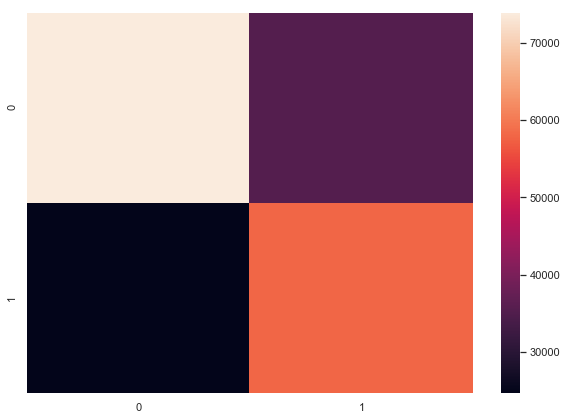

In [25]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

import seaborn as sns
plt.figure(figsize = (10,7))
sns.heatmap(confusion_matrix, annot=False)

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.68      0.71    109291
           1       0.62      0.70      0.66     82684

    accuracy                           0.69    191975
   macro avg       0.69      0.69      0.68    191975
weighted avg       0.69      0.69      0.69    191975



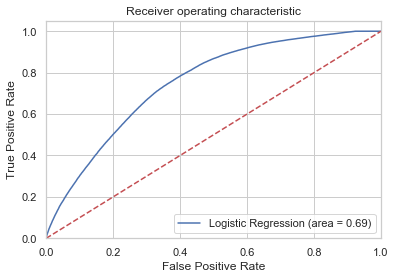

In [27]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [28]:
logreg.predict_proba(X_test)[:,1]

array([0.5936504 , 0.39096071, 0.1975225 , ..., 0.66042983, 0.47169411,
       0.33464433])

In [29]:
y_pred_df = pd.DataFrame(y_pred)
y_test_np = y_test.to_numpy()
y_pred_np = y_pred_df.to_numpy()
check_prediction_df = pd.DataFrame(np.concatenate((y_test_np, y_pred_np), axis=1))
check_prediction_df[0] = check_prediction_df[0] + 1
check_prediction_df[1] = check_prediction_df[1] + 1
check_prediction_df['correct'] = np.where(check_prediction_df[0] == check_prediction_df[1], 'yes', 'no')

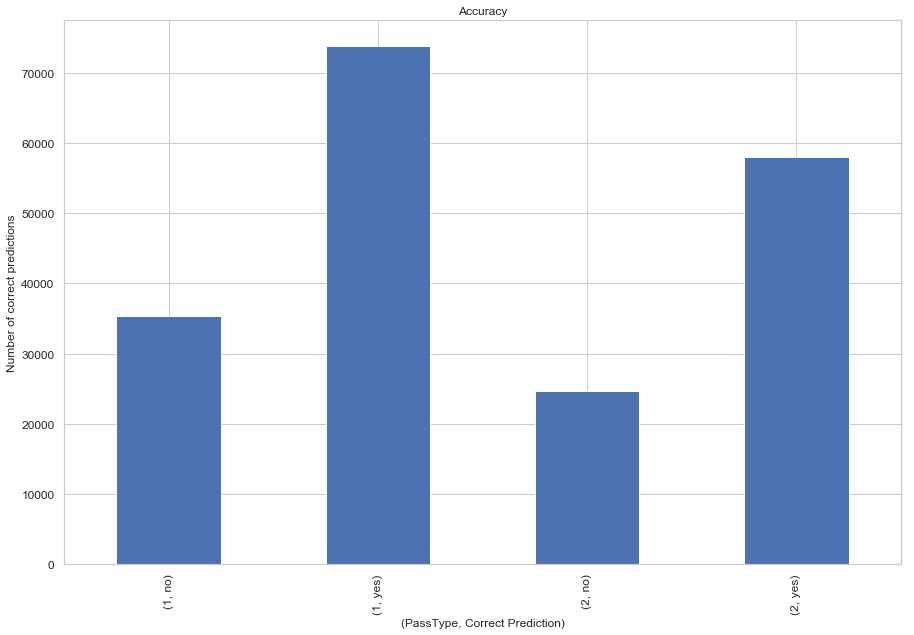

In [30]:
agg_df = check_prediction_df.groupby([0,'correct']).count()
ax = agg_df.plot(kind='bar', title ="Accuracy", figsize=(15, 10), legend=False, fontsize=12)
ax.set_xlabel("(PassType, Correct Prediction)", fontsize=12)
ax.set_ylabel("Number of correct predictions", fontsize=12)
plt.show()